In [1]:
# install python-metar
# git clone https://github.com/python-metar/python-metar
# cd python-metar
# python setup.py install

In [2]:
from __future__ import print_function

import os
import sys
import getopt
import string
import pandas as pd
import geopandas as gpd
import requests

try:
    from urllib2 import urlopen
except:
    from urllib.request import urlopen
from metar import Metar

In [3]:
URL = "https://davidmegginson.github.io/ourairports-data/airports.csv"
response = requests.get(URL)
open("airports.csv", "wb").write(response.content)

df_airports = pd.read_csv('airports.csv')
df_airports = gpd.GeoDataFrame(df_airports, geometry=gpd.points_from_xy(df_airports.longitude_deg, df_airports.latitude_deg))
df_airports.crs = 'epsg:4326'

continent = "AF"
country = "MA"

df_airports_continent = df_airports[df_airports["continent"]==continent].reset_index(drop=True)
df_airports_country = df_airports_continent[df_airports_continent["iso_country"]==country].reset_index(drop=True)


In [4]:
df_airports_country.head()

id ident            type                name  latitude_deg  \
0   3100  GMAA   small_airport    Inezgane Airport     30.381399   
1   3101  GMAD  medium_airport  Al Massira Airport     30.322478   
2   3102  GMAT  medium_airport     Tan Tan Airport     28.448200   
3  30573  GMAZ   small_airport      Zagora Airport     30.320299   
4  30228  GMFA   small_airport    Ouezzane Airport     34.783298   

   longitude_deg  elevation_ft continent iso_country iso_region  \
0      -9.546310          89.0        AF          MA     MA-AGD   
1      -9.412003         250.0        AF          MA     MA-AGD   
2     -11.161300         653.0        AF          MA     MA-TNT   
3      -5.866670        2631.0        AF          MA     MA-TIZ   
4      -5.633330         571.0        AF          MA     MA-TET   

      municipality scheduled_service gps_code iata_code local_code home_link  \
0         Inezgane                no     GMAA       NaN        NaN       NaN   
1  Agadir (Temsia)               yes     GMAD       AGA        NaN       NaN   
2          Tan Tan               yes     GMAT       TTA        NaN       NaN   
3           Zagora                no     GMAZ       OZG        NaN       NaN   
4       Beni Malek                no     GMFA       NaN        NaN       NaN   

                                     wikipedia_link  \
0    https://en.wikipedia.org/wiki/Inezgane_Airport   
1  https://en.wikipedia.org/wiki/Al_Massira_Airport   
2     https://en.wikipedia.org/wiki/Tan_Tan_Airport   
3                                               NaN   
4                                               NaN   

                                     keywords                    geometry  
0  Agadir-Inezgane Airport, Inezgane Air Base   POINT (-9.54631 30.38140)  
1                                         NaN   POINT (-9.41200 30.32248)  
2                       Plage Blanche Airport  POINT (-11.16130 28.44820)  
3                                         NaN   POINT (-5.86667 30.32030)  
4                                         NaN   POINT (-5.63333 34.78330)

In [5]:
import plotly.express as px

fig = px.scatter_mapbox(df_airports_country, lat="latitude_deg", lon="longitude_deg", hover_name="name", # hover_data=["State", "Population"],
                        color_discrete_sequence=["fuchsia"], zoom=3, height=600)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [6]:
stations = df_airports_country["gps_code"]

BASE_URL = "http://tgftp.nws.noaa.gov/data/observations/metar/stations"
debug = False
metar_df = pd.DataFrame()

for name in stations:
    try:
        
        url = "%s/%s.TXT" % (BASE_URL, name)
        if debug:
            sys.stderr.write("[ " + url + " ]")
        try:
            urlh = urlopen(url)
            report = ""
            for line in urlh:
                if not isinstance(line, str):
                    line = line.decode()  # convert Python3 bytes buffer to string
                if line.startswith(name):
                    report = line.strip()
                    obs = Metar.Metar(line)
                    metar_df = metar_df.append(pd.DataFrame({"airport":obs.station_id, "time":obs.time, "temp":obs.temp},index=[0]))
                    print(obs.string())
                    break
            if not report:
                print("No data for ", name, "\n\n")
        except Metar.ParserError as exc:
            print("METAR code: ", line)
            print(string.join(exc.args, ", "), "\n")
        except:
            import traceback

            print(traceback.format_exc())
            print("Error retrieving", name, "data", "\n")

        

    except:
        print("issue with %s" % (name))

    

METAR code:  GMAA 241000Z 26007KT 5000 SCT013 SCT016 23/21 Q1013 NOSIG B2+3

issue with GMAA


/tmp/ipykernel_12190/989147683.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



station: GMAD
type: routine report, cycle 17 (automatic report)
time: Fri May 27 17:30:00 2022
temperature: 30.0 C
dew point: 14.0 C
wind: SE at 11 knots
visibility: 10000 meters
pressure: 1015.0 mb
METAR: GMAD 271730Z 13011KT CAVOK 30/14 Q1015 NOSIG



/tmp/ipykernel_12190/989147683.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



station: GMAT
type: routine report, cycle 17 (automatic report)
time: Fri May 27 17:00:00 2022
temperature: 22.0 C
dew point: 16.0 C
wind: N at 13 knots
visibility: 8000 meters
pressure: 1014.0 mb
sky: clear
METAR: GMAT 271700Z 36013KT 8000 NSC 22/16 Q1014 NOSIG

Traceback (most recent call last):
  File "/tmp/ipykernel_12190/989147683.py", line 14, in <cell line: 7>
    urlh = urlopen(url)
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 214, in urlopen
    return opener.open(url, data, timeout)
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 523, in open
    response = meth(req, response)
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 632, in http_response
    response = self.parent.error(
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 555, in error
    result = self._call_chain(*args)
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/

/tmp/ipykernel_12190/989147683.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



station: GMFB
type: routine report, cycle 17 (automatic report)
time: Tue May  3 17:00:00 2022
temperature: 35.0 C
dew point: -2.0 C
wind: WSW at 20 knots
visibility: 3000 meters
pressure: 1018.0 mb
weather: sand
sky: scattered clouds at 3000 feet
METAR: GMFB 031700Z 24020KT 3000 SA SCT030 35/M02 Q1018 NOSIG



/tmp/ipykernel_12190/989147683.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



station: GMFF
type: routine report, cycle 17 (automatic report)
time: Fri May 27 17:30:00 2022
temperature: 33.0 C
dew point: 6.0 C
wind: SW at 14 knots
visibility: greater than 10000 meters
pressure: 1016.0 mb
weather: thunderstorm
sky: scattered clouds at 3000 feet
     scattered cumulonimbus at 3300 feet
METAR: GMFF 271730Z 22014KT 9999 TS SCT030 SCT033CB 33/06 Q1016 NOSIG

METAR code:  GMFI 221700Z 37006KT 9999 SCT016 23/08 Q1027 NOSIG

issue with GMFI


/tmp/ipykernel_12190/989147683.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



station: GMFK
type: routine report, cycle 17 (automatic report)
time: Fri May 27 17:00:00 2022
temperature: 33.0 C
dew point: -1.0 C
wind: NNW at 19 knots
visibility: greater than 10000 meters
pressure: 1020.0 mb
sky: scattered clouds at 4000 feet
     a few cumulonimbus at 5000 feet
METAR: GMFK 271700Z 33019KT 9999 SCT040 FEW050CB 33/M01 Q1020 NOSIG

METAR code:  GMFM 271726Z 28008KT 220V330 8000 TS SCT023 FEW026CB 34/10 Q1016 NOSIG M8

issue with GMFM
Traceback (most recent call last):
  File "/tmp/ipykernel_12190/989147683.py", line 14, in <cell line: 7>
    urlh = urlopen(url)
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 214, in urlopen
    return opener.open(url, data, timeout)
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 523, in open
    response = meth(req, response)
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 632, in http_response
    response = self.parent.error(
  F

/tmp/ipykernel_12190/989147683.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



station: GMFO
type: routine report, cycle 17 (automatic report)
time: Fri May 27 17:30:00 2022
temperature: 28.0 C
dew point: 9.0 C
wind: NW at 13 knots
visibility: 10000 meters
pressure: 1017.0 mb
METAR: GMFO 271730Z 32013KT CAVOK 28/09 Q1017 NOSIG

Traceback (most recent call last):
  File "/tmp/ipykernel_12190/989147683.py", line 14, in <cell line: 7>
    urlh = urlopen(url)
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 214, in urlopen
    return opener.open(url, data, timeout)
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 523, in open
    response = meth(req, response)
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 632, in http_response
    response = self.parent.error(
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 555, in error
    result = self._call_chain(*args)
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", 

/tmp/ipykernel_12190/989147683.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



station: GMMB
type: routine report, cycle 17 (automatic report)
time: Fri May 27 17:00:00 2022
temperature: 27.0 C
dew point: 12.0 C
wind: W to N at 7 knots
visibility: greater than 10000 meters
pressure: 1016.0 mb
sky: a few clouds at 1600 feet
METAR: GMMB 271700Z 30007KT 260V350 9999 FEW016 27/12 Q1016 NOSIG



/tmp/ipykernel_12190/989147683.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



station: GMMC
type: routine report, cycle 17 (automatic report)
time: Fri May 27 17:00:00 2022
temperature: 25.0 C
dew point: 16.0 C
wind: NW at 8 knots
visibility: 10000 meters
pressure: 1016.0 mb
METAR: GMMC 271700Z 32008KT CAVOK 25/16 Q1016



/tmp/ipykernel_12190/989147683.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



station: GMMD
type: routine report, cycle 17 (automatic report)
time: Fri May 27 17:00:00 2022
temperature: 28.0 C
dew point: 7.0 C
wind: SSW at 13 knots
visibility: greater than 10000 meters
pressure: 1019.0 mb
sky: a few clouds at 3000 feet
     broken clouds at 10000 feet
METAR: GMMD 271700Z 20013KT 9999 FEW030 BKN100 28/07 Q1019 NOSIG



/tmp/ipykernel_12190/989147683.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



station: GMME
type: routine report, cycle 17 (automatic report)
time: Fri May 27 17:30:00 2022
temperature: 25.0 C
dew point: 18.0 C
wind: WSW to N at 5 knots
visibility: 8000 meters
pressure: 1014.0 mb
sky: a few clouds at 1600 feet
METAR: GMME 271730Z 30005KT 240V350 8000 FEW016 25/18 Q1014 NOSIG



/tmp/ipykernel_12190/989147683.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



station: GMMF
type: routine report, cycle 10 (automatic report)
time: Mon May 16 10:00:00 2022
temperature: 19.0 C
dew point: 18.0 C
wind: variable at 3 knots
visibility: 5000 meters
pressure: 1023.0 mb
sky: scattered clouds at 1600 feet
METAR: GMMF 161000Z VRB03KT 5000 SCT016 19/18 Q1023 NOSIG



/tmp/ipykernel_12190/989147683.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



station: GMMI
type: routine report, cycle 17 (automatic report)
time: Fri May 27 17:00:00 2022
temperature: 22.0 C
dew point: 17.0 C
wind: NW at 4 knots
visibility: 6000 meters
pressure: 1016.0 mb
sky: broken clouds at 3000 feet
     scattered clouds at 20000 feet
METAR: GMMI 271700Z 32004KT 6000 BKN030 SCT200 22/17 Q1016 NOSIG

Traceback (most recent call last):
  File "/tmp/ipykernel_12190/989147683.py", line 14, in <cell line: 7>
    urlh = urlopen(url)
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 214, in urlopen
    return opener.open(url, data, timeout)
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 523, in open
    response = meth(req, response)
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 632, in http_response
    response = self.parent.error(
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 555, in error
    result = self._call_chain(*arg

/tmp/ipykernel_12190/989147683.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



station: GMMN
type: routine report, cycle 17 (automatic report)
time: Fri May 27 17:30:00 2022
temperature: 27.0 C
dew point: 10.0 C
wind: NW at 10 knots
visibility: 10000 meters
pressure: 1016.0 mb
METAR: GMMN 271730Z 32010KT CAVOK 27/10 Q1016 NOSIG

METAR code:  GMMO 061553Z 25017G28KT 210V280 9999 FEW030 17/01 Q1012 M1

issue with GMMO
METAR code:  GMMS 141000Z 10005KT 9999 SCT010 17/14 Q1019 NOSIG B2 B3

issue with GMMS


/tmp/ipykernel_12190/989147683.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



station: GMMT
type: routine report, cycle 16 (automatic report)
time: Fri May  6 16:00:00 2022
temperature: 21.0 C
dew point: 19.0 C
wind: SW at 60 knots
visibility: greater than 10000 meters
pressure: 1015.0 mb
sky: overcast at 800 feet
METAR: GMMT 061600Z 22060KT 9999 OVC008 21/19 Q1015 NOSIG



/tmp/ipykernel_12190/989147683.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



station: GMMW
type: routine report, cycle 17 (automatic report)
time: Fri May 27 17:00:00 2022
temperature: 25.0 C
dew point: 8.0 C
wind: NE at 11 knots
visibility: 10000 meters
pressure: 1016.0 mb
METAR: GMMW 271700Z 05011KT CAVOK 25/08 Q1016 NOSIG



/tmp/ipykernel_12190/989147683.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



station: GMMX
type: routine report, cycle 17 (automatic report)
time: Fri May 27 17:30:00 2022
temperature: 34.0 C
dew point: 9.0 C
wind: S to SW at 10 knots
visibility: greater than 10000 meters
pressure: 1016.0 mb
sky: scattered clouds at 3000 feet
     a few cumulonimbus at 4000 feet
METAR: GMMX 271730Z 21010KT 170V230 9999 SCT030 FEW040CB 34/09 Q1016 NOSIG



/tmp/ipykernel_12190/989147683.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



station: GMMY
type: routine report, cycle 11 (automatic report)
time: Tue May 10 11:30:00 2022
temperature: 15.0 C
dew point: 5.0 C
wind: W at 11 knots
visibility: greater than 10000 meters
pressure: 1014.0 mb
sky: scattered clouds at 2300 feet
     scattered clouds at 20000 feet
METAR: GMMY 101130Z 28011KT 9999 SCT023 SCT200 15/05 Q1014 NOSIG



/tmp/ipykernel_12190/989147683.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



station: GMMZ
type: routine report, cycle 17 (automatic report)
time: Fri May 27 17:00:00 2022
temperature: 27.0 C
dew point: 6.0 C
wind: NW at 14 knots
visibility: 6000 meters
pressure: 1022.0 mb
sky: broken clouds at 4000 feet
     a few cumulonimbus at 5000 feet
METAR: GMMZ 271700Z 31014KT 6000 BKN040 FEW050CB 27/06 Q1022 NOSIG



/tmp/ipykernel_12190/989147683.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



station: GMSL
type: routine report, cycle 6 (automatic report)
time: Mon May 23 05:46:00 2022
temperature: 20.0 C
dew point: 20.0 C
wind: calm
visibility: 4000 meters
pressure: 1016.0 mb
weather: mist
sky: a few clouds at 1000 feet
     scattered clouds at 1600 feet
METAR: GMSL 230546Z 00000KT 4000 BR FEW010 SCT016 20/20 Q1016 NOSIG



/tmp/ipykernel_12190/989147683.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



station: GMTA
type: routine report, cycle 17 (automatic report)
time: Fri May 27 17:00:00 2022
temperature: 22.0 C
dew point: 15.0 C
wind: W to N at 9 knots
visibility: 10000 meters
pressure: 1016.0 mb
METAR: GMTA 271700Z 32009KT 280V360 CAVOK 22/15 Q1016 NOSIG



/tmp/ipykernel_12190/989147683.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



station: GMTN
type: routine report, cycle 17 (automatic report)
time: Fri May 27 17:00:00 2022
temperature: 22.0 C
dew point: 16.0 C
wind: NE to ESE at 8 knots
visibility: greater than 10000 meters
pressure: 1017.0 mb
sky: scattered clouds at 1300 feet
METAR: GMTN 271700Z 07008KT 040V120 9999 SCT013 22/16 Q1017 NOSIG



/tmp/ipykernel_12190/989147683.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



station: GMTT
type: routine report, cycle 17 (automatic report)
time: Fri May 27 17:30:00 2022
temperature: 29.0 C
dew point: 11.0 C
wind: E at 19 knots
visibility: 10000 meters
pressure: 1013.0 mb
METAR: GMTT 271730Z 08019KT CAVOK 29/11 Q1013 NOSIG

Traceback (most recent call last):
  File "/tmp/ipykernel_12190/989147683.py", line 14, in <cell line: 7>
    urlh = urlopen(url)
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 214, in urlopen
    return opener.open(url, data, timeout)
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 523, in open
    response = meth(req, response)
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 632, in http_response
    response = self.parent.error(
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 555, in error
    result = self._call_chain(*args)
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", 

/tmp/ipykernel_12190/989147683.py:22: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



station: GMAG
type: routine report, cycle 17 (automatic report)
time: Fri May 27 17:00:00 2022
temperature: 33.0 C
dew point: 11.0 C
wind: NE at 9 knots
visibility: 6000 meters
pressure: 1013.0 mb
sky: clear
METAR: GMAG 271700Z 05009KT 6000 NSC 33/11 Q1013 NOSIG

Traceback (most recent call last):
  File "/tmp/ipykernel_12190/989147683.py", line 14, in <cell line: 7>
    urlh = urlopen(url)
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 214, in urlopen
    return opener.open(url, data, timeout)
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 523, in open
    response = meth(req, response)
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 632, in http_response
    response = self.parent.error(
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/request.py", line 555, in error
    result = self._call_chain(*args)
  File "/home/jeremy/.pyenv/versions/3.9.6/lib/python3.9/urllib/

In [7]:
metar_df

airport                time    temp
0    GMAD 2022-05-27 17:30:00  30.0 C
0    GMAT 2022-05-27 17:00:00  22.0 C
0    GMFB 2022-05-03 17:00:00  35.0 C
0    GMFF 2022-05-27 17:30:00  33.0 C
0    GMFK 2022-05-27 17:00:00  33.0 C
0    GMFO 2022-05-27 17:30:00  28.0 C
0    GMMB 2022-05-27 17:00:00  27.0 C
0    GMMC 2022-05-27 17:00:00  25.0 C
0    GMMD 2022-05-27 17:00:00  28.0 C
0    GMME 2022-05-27 17:30:00  25.0 C
0    GMMF 2022-05-16 10:00:00  19.0 C
0    GMMI 2022-05-27 17:00:00  22.0 C
0    GMMN 2022-05-27 17:30:00  27.0 C
0    GMMT 2022-05-06 16:00:00  21.0 C
0    GMMW 2022-05-27 17:00:00  25.0 C
0    GMMX 2022-05-27 17:30:00  34.0 C
0    GMMY 2022-05-10 11:30:00  15.0 C
0    GMMZ 2022-05-27 17:00:00  27.0 C
0    GMSL 2022-05-23 05:46:00  20.0 C
0    GMTA 2022-05-27 17:00:00  22.0 C
0    GMTN 2022-05-27 17:00:00  22.0 C
0    GMTT 2022-05-27 17:30:00  29.0 C
0    GMAG 2022-05-27 17:00:00  33.0 C

In [8]:
metar_df["temp"].iloc[0].value()

30.0

In [9]:
metar_df["temp"] = metar_df.apply(lambda x: x["temp"].value(), axis=1)

In [10]:
metar_df_coords = metar_df.merge(df_airports_country[["name","latitude_deg","longitude_deg", "gps_code"]], left_on='airport', right_on='gps_code')

In [11]:
metar_df_coords

airport                time  temp                              name  \
0     GMAD 2022-05-27 17:30:00  30.0                Al Massira Airport   
1     GMAT 2022-05-27 17:00:00  22.0                   Tan Tan Airport   
2     GMFB 2022-05-03 17:00:00  35.0                   Bouarfa Airport   
3     GMFF 2022-05-27 17:30:00  33.0                     Saïss Airport   
4     GMFK 2022-05-27 17:00:00  33.0         Moulay Ali Cherif Airport   
5     GMFO 2022-05-27 17:30:00  28.0                    Angads Airport   
6     GMMB 2022-05-27 17:00:00  27.0               Ben Slimane Airport   
7     GMMC 2022-05-27 17:00:00  25.0                      Anfa Airport   
8     GMMD 2022-05-27 17:00:00  28.0               Beni Mellal Airport   
9     GMME 2022-05-27 17:30:00  25.0                Rabat-Salé Airport   
10    GMMF 2022-05-16 10:00:00  19.0                 Sidi Ifni Airport   
11    GMMI 2022-05-27 17:00:00  22.0         Essaouira-Mogador Airport   
12    GMMN 2022-05-27 17:30:00  27.0  Mohammed V International Airport   
13    GMMT 2022-05-06 16:00:00  21.0     Casablanca Tit Mellil Airport   
14    GMMW 2022-05-27 17:00:00  25.0       Nador International Airport   
15    GMMX 2022-05-27 17:30:00  34.0                    Menara Airport   
16    GMMY 2022-05-10 11:30:00  15.0                  Kenitra Air Base   
17    GMMZ 2022-05-27 17:00:00  27.0                Ouarzazate Airport   
18    GMSL 2022-05-23 05:46:00  20.0              Sidi Slimane Airport   
19    GMTA 2022-05-27 17:00:00  22.0         Cherif Al Idrissi Airport   
20    GMTN 2022-05-27 17:00:00  22.0              Saniat R'mel Airport   
21    GMTT 2022-05-27 17:30:00  29.0      Tangier Ibn Battouta Airport   
22    GMAG 2022-05-27 17:00:00  33.0                   Guelmim Airport   

    latitude_deg  longitude_deg gps_code  
0      30.322478      -9.412003     GMAD  
1      28.448200     -11.161300     GMAT  
2      32.514306      -1.983056     GMFB  
3      33.927299      -4.977960     GMFF  
4      31.947500      -4.398330     GMFK  
5      34.787201      -1.923990     GMFO  
6      33.655399      -7.221450     GMMB  
7      33.553299      -7.661390     GMMC  
8      32.401895      -6.315905     GMMD  
9      34.051498      -6.751520     GMME  
10     29.368889     -10.180278     GMMF  
11     31.397499      -9.681670     GMMI  
12     33.367500      -7.589970     GMMN  
13     33.597500      -7.465000     GMMT  
14     34.988800      -3.028210     GMMW  
15     31.606899      -8.036300     GMMX  
16     34.298901      -6.595880     GMMY  
17     30.939100      -6.909430     GMMZ  
18     34.230598      -6.050140     GMSL  
19     35.177101      -3.839520     GMTA  
20     35.594299      -5.320020     GMTN  
21     35.726898      -5.916890     GMTT  
22     29.026699     -10.050300     GMAG

In [12]:
import datetime

In [13]:
metar_df_coords["delay_last_obs_days"] = metar_df_coords.apply(lambda x: (datetime.datetime.now() - x["time"]).days, axis=1)
metar_df_coords["delay_last_obs_hours"] = metar_df_coords.apply(lambda x: (datetime.datetime.now() - x["time"]).seconds//3600, axis=1)

metar_df_coords = metar_df_coords[metar_df_coords["delay_last_obs_days"]==0]
metar_df_coords = metar_df_coords[metar_df_coords["delay_last_obs_hours"]<=6]

In [14]:
metar_df_coords

airport                time  temp                              name  \
0     GMAD 2022-05-27 17:30:00  30.0                Al Massira Airport   
1     GMAT 2022-05-27 17:00:00  22.0                   Tan Tan Airport   
3     GMFF 2022-05-27 17:30:00  33.0                     Saïss Airport   
4     GMFK 2022-05-27 17:00:00  33.0         Moulay Ali Cherif Airport   
5     GMFO 2022-05-27 17:30:00  28.0                    Angads Airport   
6     GMMB 2022-05-27 17:00:00  27.0               Ben Slimane Airport   
7     GMMC 2022-05-27 17:00:00  25.0                      Anfa Airport   
8     GMMD 2022-05-27 17:00:00  28.0               Beni Mellal Airport   
9     GMME 2022-05-27 17:30:00  25.0                Rabat-Salé Airport   
11    GMMI 2022-05-27 17:00:00  22.0         Essaouira-Mogador Airport   
12    GMMN 2022-05-27 17:30:00  27.0  Mohammed V International Airport   
14    GMMW 2022-05-27 17:00:00  25.0       Nador International Airport   
15    GMMX 2022-05-27 17:30:00  34.0                    Menara Airport   
17    GMMZ 2022-05-27 17:00:00  27.0                Ouarzazate Airport   
19    GMTA 2022-05-27 17:00:00  22.0         Cherif Al Idrissi Airport   
20    GMTN 2022-05-27 17:00:00  22.0              Saniat R'mel Airport   
21    GMTT 2022-05-27 17:30:00  29.0      Tangier Ibn Battouta Airport   
22    GMAG 2022-05-27 17:00:00  33.0                   Guelmim Airport   

    latitude_deg  longitude_deg gps_code  delay_last_obs_days  \
0      30.322478      -9.412003     GMAD                    0   
1      28.448200     -11.161300     GMAT                    0   
3      33.927299      -4.977960     GMFF                    0   
4      31.947500      -4.398330     GMFK                    0   
5      34.787201      -1.923990     GMFO                    0   
6      33.655399      -7.221450     GMMB                    0   
7      33.553299      -7.661390     GMMC                    0   
8      32.401895      -6.315905     GMMD                    0   
9      34.051498      -6.751520     GMME                    0   
11     31.397499      -9.681670     GMMI                    0   
12     33.367500      -7.589970     GMMN                    0   
14     34.988800      -3.028210     GMMW                    0   
15     31.606899      -8.036300     GMMX                    0   
17     30.939100      -6.909430     GMMZ                    0   
19     35.177101      -3.839520     GMTA                    0   
20     35.594299      -5.320020     GMTN                    0   
21     35.726898      -5.916890     GMTT                    0   
22     29.026699     -10.050300     GMAG                    0   

    delay_last_obs_hours  
0                      2  
1                      3  
3                      2  
4                      3  
5                      2  
6                      3  
7                      3  
8                      3  
9                      2  
11                     3  
12                     2  
14                     3  
15                     2  
17                     3  
19                     3  
20                     3  
21                     2  
22                     3

In [15]:
import plotly.express as px

fig = px.scatter_mapbox(metar_df_coords, lat="latitude_deg", lon="longitude_deg", hover_name="name", color="temp",#hover_data=["State", "Population"],
                        color_discrete_sequence=["fuchsia"], zoom=5, height=600)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [16]:
metar_gdf_coords = gpd.GeoDataFrame(metar_df_coords.drop(columns="time"), geometry=gpd.points_from_xy(metar_df_coords.longitude_deg, metar_df_coords.latitude_deg))
metar_gdf_coords.crs = 'epsg:4326'
metar_gdf_coords.to_file("./data/metar_df_coords.shp")

/home/jeremy/.pyenv/versions/3.9.6/envs/venv_streamlit/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/tmp/ipykernel_12190/2700367694.py:3: UserWarning:

Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.



In [17]:
from pyidw import idw

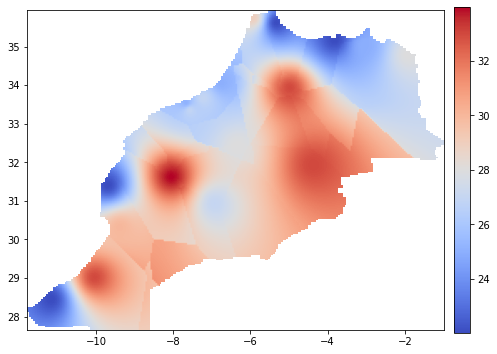

In [18]:
idw.idw_interpolation(
    input_point_shapefile="./data/metar_df_coords.shp",
    extent_shapefile="./data/mar_borders/mar_admbnda_adm0_unhcr_20201203.shp",
    column_name="temp",
    power=2,
    search_radious=4,
    output_resolution=250,
)

In [19]:
from pyidw import idw
from sklearn.metrics import mean_squared_error

original_value, interpolated_value = idw.accuracy_standard_idw(
    input_point_shapefile="./data/metar_df_coords.shp",
    extent_shapefile="./data/mar_borders/mar_admbnda_adm0_unhcr_20201203.shp",
    column_name="temp",
    power=2,
    search_radious=4,
    output_resolution=250,
)

print("RMSE:", mean_squared_error(original_value, interpolated_value, squared=False))

RMSE: 4.127409806168764


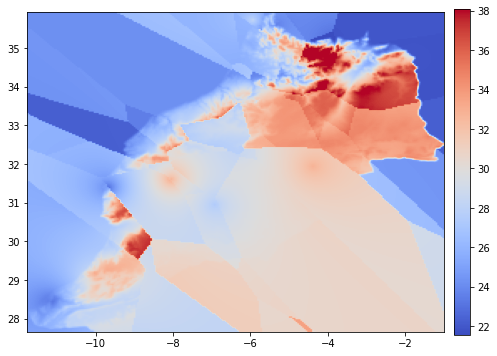

In [20]:
from pyidw import idw

idw.regression_idw_interpolation(
    input_point_shapefile="./data/metar_df_coords.shp",
    input_raster_file="./data/DEM_MA_2.tiff",
    extent_shapefile="./data/mar_borders/mar_admbnda_adm0_unhcr_20201203.shp",
    column_name="temp",
    power=1,
    polynomial_degree=1,
    search_radious=4,
    output_resolution=250,
)

In [21]:
#from selenium import webdriver
#from selenium.webdriver.firefox.firefox_binary import FirefoxBinary
#binary = FirefoxBinary('/usr/local/bin')
#browser = webdriver.Firefox(firefox_binary=binary)

In [22]:
from selenium import webdriver
from time import sleep
from selenium.webdriver import FirefoxOptions

opts = FirefoxOptions()
opts.add_argument("--headless")

# https://stackoverflow.com/questions/41190989/how-do-i-install-geckodriver
# https://stackoverflow.com/questions/46809135/webdriver-exceptionprocess-unexpectedly-closed-with-status-1
# pip install webdrivermanager
# sudo apt-get install firefox
# webdrivermanager firefox --linkpath /usr/local/bin
# sudo apt install firefox-geckodriver

driver = webdriver.Firefox(options=opts)
driver.set_window_size(900, 900)
driver.get('http://trema.ucam.ac.ma/Obs_TREMA/index.html')
sleep(10)

driver.get_screenshot_as_file("./data/screenshot.png")
driver.quit()
print("end...")



end...


In [23]:
import re
import cv2 
import numpy as np
import pytesseract
from pytesseract import Output
from matplotlib import pyplot as plt




In [24]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

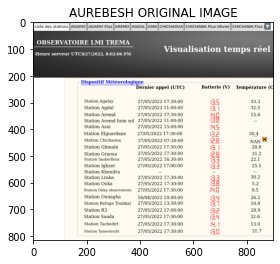

In [25]:

image = cv2.imread('./data/screenshot.png')
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.imshow(rgb_img)
plt.title('AUREBESH ORIGINAL IMAGE')
plt.show()

In [26]:
# Preprocess image 

gray = get_grayscale(image)
thresh = thresholding(gray)
opening = opening(gray)
canny = canny(gray)
images = {'gray': gray, 
          'thresh': thresh, 
          'opening': opening, 
          'canny': canny}

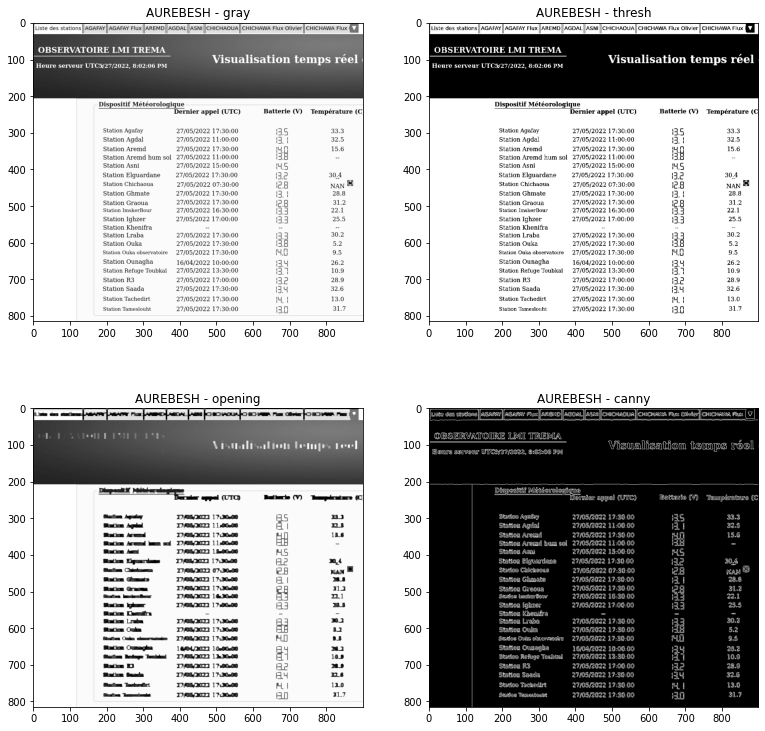

In [27]:
# Plot images after preprocessing

fig = plt.figure(figsize=(13,13))
ax = []

rows = 2
columns = 2
keys = list(images.keys())
for i in range(rows*columns):
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title('AUREBESH - ' + keys[i]) 
    plt.imshow(images[keys[i]], cmap='gray') 

In [28]:
import pandas as pd
from io import StringIO

# Get OCR output using Pytesseract

custom_config = r'--oem 3 --psm 6'
text = pytesseract.image_to_string(image, config=custom_config)
text = StringIO(text)
df_parse_lmi = pd.read_csv(text, sep="  ")
df_parse_lmi

/tmp/ipykernel_12190/3516130720.py:9: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



Liste des stations || AGAFAY|| AGAFAY Flux |/AREMD |] AGDAL | [as] |CHICHAQUA || CHICHAWA Flux Olivier|| CHICHAWA Flux a
0                            OBSERVATOIRE LMI TREMA ,                                                                      
1                            Visualisation temps réel                                                                      
2              Heure serveur UTC5/27/2022, 8:02:06 PM                                                                      
3                           Dispositif Météorologique                                                                      
4     Dernier appel (UTC) Batterie (V) Température (C                                                                      
5             Station Agafay 27/05/2022 17:30:00 33.3                                                                      
6              Station Agdal 27/05/2022 11:00:00 32.5                                                                      
7              Station Aremd 27/05/2022 17:30:00 15.6                                                                      
8         Station Aremd hum sol 27/05/2022 11:00:00 -                                                                      
9                    Station Asni 27/05/2022 15:00:00                                                                      
10        Station Elguardane 27/05/2022 17:30:00 30.4                                                                      
11        Station Chichaoua 27/05/2022 07:30:00 nan &                                                                      
12            Station Ghmate 27/05/2022 17:30:00 28.8                                                                      
13            Station Graoua 27/05/2022 17:30:00 31.2                                                                      
14        Station ImskerBour 27/05/2022 16:30:00 22.1                                                                      
15            Station Ighzer 27/05/2022 17:00:00 25.5                                                                      
16                             Station Khenifra = = -                                                                      
17             Station Lraba 27/05/2022 17:30:00 30.2                                                                      
18               Station Ouka 27/05/2022 17:30:00 5.2                                                                      
19  Station Ouka observatoire 27/05/2022 17:30:00 9.5                                                                      
20           Station Ounagha 16/04/2022 10:00:00 26.2                                                                      
21    Station Refuge Toubkal 27/05/2022 13:30:00 10.9                                                                      
22                Station R3 27/05/2022 17:00:00 28.9                                                                      
23             Station Saada 27/05/2022 17:30:00 32.6                                                                      
24         Station Tachedirt 27/05/2022 17:30:00 13.0                                                                      
25        Station Tameslouht 27/05/2022 17:30:00 31.7

In [29]:
df_parse_lmi = df_parse_lmi[5:].reset_index(drop=True)
df_parse_lmi

Liste des stations || AGAFAY|| AGAFAY Flux |/AREMD |] AGDAL | [as] |CHICHAQUA || CHICHAWA Flux Olivier|| CHICHAWA Flux a
0             Station Agafay 27/05/2022 17:30:00 33.3                                                                      
1              Station Agdal 27/05/2022 11:00:00 32.5                                                                      
2              Station Aremd 27/05/2022 17:30:00 15.6                                                                      
3         Station Aremd hum sol 27/05/2022 11:00:00 -                                                                      
4                    Station Asni 27/05/2022 15:00:00                                                                      
5         Station Elguardane 27/05/2022 17:30:00 30.4                                                                      
6         Station Chichaoua 27/05/2022 07:30:00 nan &                                                                      
7             Station Ghmate 27/05/2022 17:30:00 28.8                                                                      
8             Station Graoua 27/05/2022 17:30:00 31.2                                                                      
9         Station ImskerBour 27/05/2022 16:30:00 22.1                                                                      
10            Station Ighzer 27/05/2022 17:00:00 25.5                                                                      
11                             Station Khenifra = = -                                                                      
12             Station Lraba 27/05/2022 17:30:00 30.2                                                                      
13               Station Ouka 27/05/2022 17:30:00 5.2                                                                      
14  Station Ouka observatoire 27/05/2022 17:30:00 9.5                                                                      
15           Station Ounagha 16/04/2022 10:00:00 26.2                                                                      
16    Station Refuge Toubkal 27/05/2022 13:30:00 10.9                                                                      
17                Station R3 27/05/2022 17:00:00 28.9                                                                      
18             Station Saada 27/05/2022 17:30:00 32.6                                                                      
19         Station Tachedirt 27/05/2022 17:30:00 13.0                                                                      
20        Station Tameslouht 27/05/2022 17:30:00 31.7

In [30]:
df_parse_lmi=df_parse_lmi.rename(columns={df_parse_lmi.columns[0]:"values"})

In [31]:
df_parse_lmi["temp"] = df_parse_lmi.apply(lambda x: x["values"].split(" ")[-1], axis=1)
df_parse_lmi["hour"] = df_parse_lmi.apply(lambda x: x["values"].split(" ")[-2], axis=1)
df_parse_lmi["date"] = df_parse_lmi.apply(lambda x: x["values"].split(" ")[-3], axis=1)

In [32]:
df_parse_lmi

values      temp        hour  \
0             Station Agafay 27/05/2022 17:30:00 33.3      33.3    17:30:00   
1              Station Agdal 27/05/2022 11:00:00 32.5      32.5    11:00:00   
2              Station Aremd 27/05/2022 17:30:00 15.6      15.6    17:30:00   
3         Station Aremd hum sol 27/05/2022 11:00:00 -         -    11:00:00   
4                    Station Asni 27/05/2022 15:00:00  15:00:00  27/05/2022   
5         Station Elguardane 27/05/2022 17:30:00 30.4      30.4    17:30:00   
6         Station Chichaoua 27/05/2022 07:30:00 nan &         &         nan   
7             Station Ghmate 27/05/2022 17:30:00 28.8      28.8    17:30:00   
8             Station Graoua 27/05/2022 17:30:00 31.2      31.2    17:30:00   
9         Station ImskerBour 27/05/2022 16:30:00 22.1      22.1    16:30:00   
10            Station Ighzer 27/05/2022 17:00:00 25.5      25.5    17:00:00   
11                             Station Khenifra = = -         -           =   
12             Station Lraba 27/05/2022 17:30:00 30.2      30.2    17:30:00   
13               Station Ouka 27/05/2022 17:30:00 5.2       5.2    17:30:00   
14  Station Ouka observatoire 27/05/2022 17:30:00 9.5       9.5    17:30:00   
15           Station Ounagha 16/04/2022 10:00:00 26.2      26.2    10:00:00   
16    Station Refuge Toubkal 27/05/2022 13:30:00 10.9      10.9    13:30:00   
17                Station R3 27/05/2022 17:00:00 28.9      28.9    17:00:00   
18             Station Saada 27/05/2022 17:30:00 32.6      32.6    17:30:00   
19         Station Tachedirt 27/05/2022 17:30:00 13.0      13.0    17:30:00   
20        Station Tameslouht 27/05/2022 17:30:00 31.7      31.7    17:30:00   

          date  
0   27/05/2022  
1   27/05/2022  
2   27/05/2022  
3   27/05/2022  
4         Asni  
5   27/05/2022  
6     07:30:00  
7   27/05/2022  
8   27/05/2022  
9   27/05/2022  
10  27/05/2022  
11           =  
12  27/05/2022  
13  27/05/2022  
14  27/05/2022  
15  16/04/2022  
16  27/05/2022  
17  27/05/2022  
18  27/05/2022  
19  27/05/2022  
20  27/05/2022

In [33]:
for i in range(len(df_parse_lmi)):
    try:
        df_parse_lmi.loc[i,"temp"] = float(df_parse_lmi.loc[i,"temp"])
    except:
        df_parse_lmi.loc[i,"temp"] = np.nan

In [34]:
df_parse_lmi = df_parse_lmi.dropna().reset_index(drop=True)

In [35]:
df_parse_lmi

values  temp      hour  \
0             Station Agafay 27/05/2022 17:30:00 33.3  33.3  17:30:00   
1              Station Agdal 27/05/2022 11:00:00 32.5  32.5  11:00:00   
2              Station Aremd 27/05/2022 17:30:00 15.6  15.6  17:30:00   
3         Station Elguardane 27/05/2022 17:30:00 30.4  30.4  17:30:00   
4             Station Ghmate 27/05/2022 17:30:00 28.8  28.8  17:30:00   
5             Station Graoua 27/05/2022 17:30:00 31.2  31.2  17:30:00   
6         Station ImskerBour 27/05/2022 16:30:00 22.1  22.1  16:30:00   
7             Station Ighzer 27/05/2022 17:00:00 25.5  25.5  17:00:00   
8              Station Lraba 27/05/2022 17:30:00 30.2  30.2  17:30:00   
9                Station Ouka 27/05/2022 17:30:00 5.2   5.2  17:30:00   
10  Station Ouka observatoire 27/05/2022 17:30:00 9.5   9.5  17:30:00   
11           Station Ounagha 16/04/2022 10:00:00 26.2  26.2  10:00:00   
12    Station Refuge Toubkal 27/05/2022 13:30:00 10.9  10.9  13:30:00   
13                Station R3 27/05/2022 17:00:00 28.9  28.9  17:00:00   
14             Station Saada 27/05/2022 17:30:00 32.6  32.6  17:30:00   
15         Station Tachedirt 27/05/2022 17:30:00 13.0  13.0  17:30:00   
16        Station Tameslouht 27/05/2022 17:30:00 31.7  31.7  17:30:00   

          date  
0   27/05/2022  
1   27/05/2022  
2   27/05/2022  
3   27/05/2022  
4   27/05/2022  
5   27/05/2022  
6   27/05/2022  
7   27/05/2022  
8   27/05/2022  
9   27/05/2022  
10  27/05/2022  
11  16/04/2022  
12  27/05/2022  
13  27/05/2022  
14  27/05/2022  
15  27/05/2022  
16  27/05/2022

In [36]:
df_parse_lmi["temp"] = df_parse_lmi.apply(lambda x: float(x["temp"]), axis=1)

In [37]:
from datetime import datetime as dt
df_parse_lmi["datetime"] = df_parse_lmi.apply(lambda x: dt.strptime(x["hour"]+" "+ x["date"], "%H:%M:%S %d/%m/%Y"), axis=1)

In [38]:
df_parse_lmi["station"] =  df_parse_lmi.apply(lambda x: x["values"].split(" ")[1], axis=1)

In [39]:
df_parse_lmi

values  temp      hour  \
0             Station Agafay 27/05/2022 17:30:00 33.3  33.3  17:30:00   
1              Station Agdal 27/05/2022 11:00:00 32.5  32.5  11:00:00   
2              Station Aremd 27/05/2022 17:30:00 15.6  15.6  17:30:00   
3         Station Elguardane 27/05/2022 17:30:00 30.4  30.4  17:30:00   
4             Station Ghmate 27/05/2022 17:30:00 28.8  28.8  17:30:00   
5             Station Graoua 27/05/2022 17:30:00 31.2  31.2  17:30:00   
6         Station ImskerBour 27/05/2022 16:30:00 22.1  22.1  16:30:00   
7             Station Ighzer 27/05/2022 17:00:00 25.5  25.5  17:00:00   
8              Station Lraba 27/05/2022 17:30:00 30.2  30.2  17:30:00   
9                Station Ouka 27/05/2022 17:30:00 5.2   5.2  17:30:00   
10  Station Ouka observatoire 27/05/2022 17:30:00 9.5   9.5  17:30:00   
11           Station Ounagha 16/04/2022 10:00:00 26.2  26.2  10:00:00   
12    Station Refuge Toubkal 27/05/2022 13:30:00 10.9  10.9  13:30:00   
13                Station R3 27/05/2022 17:00:00 28.9  28.9  17:00:00   
14             Station Saada 27/05/2022 17:30:00 32.6  32.6  17:30:00   
15         Station Tachedirt 27/05/2022 17:30:00 13.0  13.0  17:30:00   
16        Station Tameslouht 27/05/2022 17:30:00 31.7  31.7  17:30:00   

          date            datetime     station  
0   27/05/2022 2022-05-27 17:30:00      Agafay  
1   27/05/2022 2022-05-27 11:00:00       Agdal  
2   27/05/2022 2022-05-27 17:30:00       Aremd  
3   27/05/2022 2022-05-27 17:30:00  Elguardane  
4   27/05/2022 2022-05-27 17:30:00      Ghmate  
5   27/05/2022 2022-05-27 17:30:00      Graoua  
6   27/05/2022 2022-05-27 16:30:00  ImskerBour  
7   27/05/2022 2022-05-27 17:00:00      Ighzer  
8   27/05/2022 2022-05-27 17:30:00       Lraba  
9   27/05/2022 2022-05-27 17:30:00        Ouka  
10  27/05/2022 2022-05-27 17:30:00        Ouka  
11  16/04/2022 2022-04-16 10:00:00     Ounagha  
12  27/05/2022 2022-05-27 13:30:00      Refuge  
13  27/05/2022 2022-05-27 17:00:00          R3  
14  27/05/2022 2022-05-27 17:30:00       Saada  
15  27/05/2022 2022-05-27 17:30:00   Tachedirt  
16  27/05/2022 2022-05-27 17:30:00  Tameslouht

In [40]:
df_parse_lmi = df_parse_lmi.drop(df_parse_lmi[df_parse_lmi["station"]=="Ouka"].index[1]).reset_index(drop=True)

In [41]:
df_stations = pd.read_csv("station_LMI.csv", sep=";",header=None,index_col=0)
df_stations = df_stations.drop(labels=10, axis=0)
df_stations

1          2         3
0                                  
0       Agafay  31.501453 -8.244994
1        Agdal  31.598568 -7.981433
2        Aremd  31.124616 -7.920203
3   Elguardane  30.358047 -8.982468
4       Ghmate  31.422740 -7.802908
5       Graoua  31.584441 -7.916415
6   ImskerBour  31.204559 -7.939708
7       Ighzer  31.141792 -8.495583
8        Lraba  31.660892 -7.677483
9         Ouka  31.181801 -7.865382
11     Ounagha  31.440571 -9.280904
12      Refuge  31.063718 -7.937852
13          R3  31.653208 -7.604235
14       Saada  31.628440 -8.156659
15   Tachedirt  31.155546 -7.847478
16  Tameslouht  31.497455 -8.094303

In [42]:
df_parse_lmi = df_parse_lmi.merge(df_stations, left_on="station", right_on=1, how="outer")
df_parse_lmi

values  temp      hour  \
0           Station Agafay 27/05/2022 17:30:00 33.3  33.3  17:30:00   
1            Station Agdal 27/05/2022 11:00:00 32.5  32.5  11:00:00   
2            Station Aremd 27/05/2022 17:30:00 15.6  15.6  17:30:00   
3       Station Elguardane 27/05/2022 17:30:00 30.4  30.4  17:30:00   
4           Station Ghmate 27/05/2022 17:30:00 28.8  28.8  17:30:00   
5           Station Graoua 27/05/2022 17:30:00 31.2  31.2  17:30:00   
6       Station ImskerBour 27/05/2022 16:30:00 22.1  22.1  16:30:00   
7           Station Ighzer 27/05/2022 17:00:00 25.5  25.5  17:00:00   
8            Station Lraba 27/05/2022 17:30:00 30.2  30.2  17:30:00   
9              Station Ouka 27/05/2022 17:30:00 5.2   5.2  17:30:00   
10         Station Ounagha 16/04/2022 10:00:00 26.2  26.2  10:00:00   
11  Station Refuge Toubkal 27/05/2022 13:30:00 10.9  10.9  13:30:00   
12              Station R3 27/05/2022 17:00:00 28.9  28.9  17:00:00   
13           Station Saada 27/05/2022 17:30:00 32.6  32.6  17:30:00   
14       Station Tachedirt 27/05/2022 17:30:00 13.0  13.0  17:30:00   
15      Station Tameslouht 27/05/2022 17:30:00 31.7  31.7  17:30:00   

          date            datetime     station           1          2  \
0   27/05/2022 2022-05-27 17:30:00      Agafay      Agafay  31.501453   
1   27/05/2022 2022-05-27 11:00:00       Agdal       Agdal  31.598568   
2   27/05/2022 2022-05-27 17:30:00       Aremd       Aremd  31.124616   
3   27/05/2022 2022-05-27 17:30:00  Elguardane  Elguardane  30.358047   
4   27/05/2022 2022-05-27 17:30:00      Ghmate      Ghmate  31.422740   
5   27/05/2022 2022-05-27 17:30:00      Graoua      Graoua  31.584441   
6   27/05/2022 2022-05-27 16:30:00  ImskerBour  ImskerBour  31.204559   
7   27/05/2022 2022-05-27 17:00:00      Ighzer      Ighzer  31.141792   
8   27/05/2022 2022-05-27 17:30:00       Lraba       Lraba  31.660892   
9   27/05/2022 2022-05-27 17:30:00        Ouka        Ouka  31.181801   
10  16/04/2022 2022-04-16 10:00:00     Ounagha     Ounagha  31.440571   
11  27/05/2022 2022-05-27 13:30:00      Refuge      Refuge  31.063718   
12  27/05/2022 2022-05-27 17:00:00          R3          R3  31.653208   
13  27/05/2022 2022-05-27 17:30:00       Saada       Saada  31.628440   
14  27/05/2022 2022-05-27 17:30:00   Tachedirt   Tachedirt  31.155546   
15  27/05/2022 2022-05-27 17:30:00  Tameslouht  Tameslouht  31.497455   

           3  
0  -8.244994  
1  -7.981433  
2  -7.920203  
3  -8.982468  
4  -7.802908  
5  -7.916415  
6  -7.939708  
7  -8.495583  
8  -7.677483  
9  -7.865382  
10 -9.280904  
11 -7.937852  
12 -7.604235  
13 -8.156659  
14 -7.847478  
15 -8.094303

In [43]:
df_parse_lmi = df_parse_lmi.rename(columns={"station":"name", 2:"latitude_deg", 3:"longitude_deg", "datetime":"time"})

In [44]:
df_parse_lmi

values  temp      hour  \
0           Station Agafay 27/05/2022 17:30:00 33.3  33.3  17:30:00   
1            Station Agdal 27/05/2022 11:00:00 32.5  32.5  11:00:00   
2            Station Aremd 27/05/2022 17:30:00 15.6  15.6  17:30:00   
3       Station Elguardane 27/05/2022 17:30:00 30.4  30.4  17:30:00   
4           Station Ghmate 27/05/2022 17:30:00 28.8  28.8  17:30:00   
5           Station Graoua 27/05/2022 17:30:00 31.2  31.2  17:30:00   
6       Station ImskerBour 27/05/2022 16:30:00 22.1  22.1  16:30:00   
7           Station Ighzer 27/05/2022 17:00:00 25.5  25.5  17:00:00   
8            Station Lraba 27/05/2022 17:30:00 30.2  30.2  17:30:00   
9              Station Ouka 27/05/2022 17:30:00 5.2   5.2  17:30:00   
10         Station Ounagha 16/04/2022 10:00:00 26.2  26.2  10:00:00   
11  Station Refuge Toubkal 27/05/2022 13:30:00 10.9  10.9  13:30:00   
12              Station R3 27/05/2022 17:00:00 28.9  28.9  17:00:00   
13           Station Saada 27/05/2022 17:30:00 32.6  32.6  17:30:00   
14       Station Tachedirt 27/05/2022 17:30:00 13.0  13.0  17:30:00   
15      Station Tameslouht 27/05/2022 17:30:00 31.7  31.7  17:30:00   

          date                time        name           1  latitude_deg  \
0   27/05/2022 2022-05-27 17:30:00      Agafay      Agafay     31.501453   
1   27/05/2022 2022-05-27 11:00:00       Agdal       Agdal     31.598568   
2   27/05/2022 2022-05-27 17:30:00       Aremd       Aremd     31.124616   
3   27/05/2022 2022-05-27 17:30:00  Elguardane  Elguardane     30.358047   
4   27/05/2022 2022-05-27 17:30:00      Ghmate      Ghmate     31.422740   
5   27/05/2022 2022-05-27 17:30:00      Graoua      Graoua     31.584441   
6   27/05/2022 2022-05-27 16:30:00  ImskerBour  ImskerBour     31.204559   
7   27/05/2022 2022-05-27 17:00:00      Ighzer      Ighzer     31.141792   
8   27/05/2022 2022-05-27 17:30:00       Lraba       Lraba     31.660892   
9   27/05/2022 2022-05-27 17:30:00        Ouka        Ouka     31.181801   
10  16/04/2022 2022-04-16 10:00:00     Ounagha     Ounagha     31.440571   
11  27/05/2022 2022-05-27 13:30:00      Refuge      Refuge     31.063718   
12  27/05/2022 2022-05-27 17:00:00          R3          R3     31.653208   
13  27/05/2022 2022-05-27 17:30:00       Saada       Saada     31.628440   
14  27/05/2022 2022-05-27 17:30:00   Tachedirt   Tachedirt     31.155546   
15  27/05/2022 2022-05-27 17:30:00  Tameslouht  Tameslouht     31.497455   

    longitude_deg  
0       -8.244994  
1       -7.981433  
2       -7.920203  
3       -8.982468  
4       -7.802908  
5       -7.916415  
6       -7.939708  
7       -8.495583  
8       -7.677483  
9       -7.865382  
10      -9.280904  
11      -7.937852  
12      -7.604235  
13      -8.156659  
14      -7.847478  
15      -8.094303

In [45]:
metar_df_coords

airport                time  temp                              name  \
0     GMAD 2022-05-27 17:30:00  30.0                Al Massira Airport   
1     GMAT 2022-05-27 17:00:00  22.0                   Tan Tan Airport   
3     GMFF 2022-05-27 17:30:00  33.0                     Saïss Airport   
4     GMFK 2022-05-27 17:00:00  33.0         Moulay Ali Cherif Airport   
5     GMFO 2022-05-27 17:30:00  28.0                    Angads Airport   
6     GMMB 2022-05-27 17:00:00  27.0               Ben Slimane Airport   
7     GMMC 2022-05-27 17:00:00  25.0                      Anfa Airport   
8     GMMD 2022-05-27 17:00:00  28.0               Beni Mellal Airport   
9     GMME 2022-05-27 17:30:00  25.0                Rabat-Salé Airport   
11    GMMI 2022-05-27 17:00:00  22.0         Essaouira-Mogador Airport   
12    GMMN 2022-05-27 17:30:00  27.0  Mohammed V International Airport   
14    GMMW 2022-05-27 17:00:00  25.0       Nador International Airport   
15    GMMX 2022-05-27 17:30:00  34.0                    Menara Airport   
17    GMMZ 2022-05-27 17:00:00  27.0                Ouarzazate Airport   
19    GMTA 2022-05-27 17:00:00  22.0         Cherif Al Idrissi Airport   
20    GMTN 2022-05-27 17:00:00  22.0              Saniat R'mel Airport   
21    GMTT 2022-05-27 17:30:00  29.0      Tangier Ibn Battouta Airport   
22    GMAG 2022-05-27 17:00:00  33.0                   Guelmim Airport   

    latitude_deg  longitude_deg gps_code  delay_last_obs_days  \
0      30.322478      -9.412003     GMAD                    0   
1      28.448200     -11.161300     GMAT                    0   
3      33.927299      -4.977960     GMFF                    0   
4      31.947500      -4.398330     GMFK                    0   
5      34.787201      -1.923990     GMFO                    0   
6      33.655399      -7.221450     GMMB                    0   
7      33.553299      -7.661390     GMMC                    0   
8      32.401895      -6.315905     GMMD                    0   
9      34.051498      -6.751520     GMME                    0   
11     31.397499      -9.681670     GMMI                    0   
12     33.367500      -7.589970     GMMN                    0   
14     34.988800      -3.028210     GMMW                    0   
15     31.606899      -8.036300     GMMX                    0   
17     30.939100      -6.909430     GMMZ                    0   
19     35.177101      -3.839520     GMTA                    0   
20     35.594299      -5.320020     GMTN                    0   
21     35.726898      -5.916890     GMTT                    0   
22     29.026699     -10.050300     GMAG                    0   

    delay_last_obs_hours  
0                      2  
1                      3  
3                      2  
4                      3  
5                      2  
6                      3  
7                      3  
8                      3  
9                      2  
11                     3  
12                     2  
14                     3  
15                     2  
17                     3  
19                     3  
20                     3  
21                     2  
22                     3

In [46]:
metar_df_coords = metar_df_coords.append(df_parse_lmi[["name","latitude_deg","longitude_deg","temp","time"]]).reset_index(drop=True)

/tmp/ipykernel_12190/1725033513.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [47]:
metar_df_coords

airport                time  temp                              name  \
0     GMAD 2022-05-27 17:30:00  30.0                Al Massira Airport   
1     GMAT 2022-05-27 17:00:00  22.0                   Tan Tan Airport   
2     GMFF 2022-05-27 17:30:00  33.0                     Saïss Airport   
3     GMFK 2022-05-27 17:00:00  33.0         Moulay Ali Cherif Airport   
4     GMFO 2022-05-27 17:30:00  28.0                    Angads Airport   
5     GMMB 2022-05-27 17:00:00  27.0               Ben Slimane Airport   
6     GMMC 2022-05-27 17:00:00  25.0                      Anfa Airport   
7     GMMD 2022-05-27 17:00:00  28.0               Beni Mellal Airport   
8     GMME 2022-05-27 17:30:00  25.0                Rabat-Salé Airport   
9     GMMI 2022-05-27 17:00:00  22.0         Essaouira-Mogador Airport   
10    GMMN 2022-05-27 17:30:00  27.0  Mohammed V International Airport   
11    GMMW 2022-05-27 17:00:00  25.0       Nador International Airport   
12    GMMX 2022-05-27 17:30:00  34.0                    Menara Airport   
13    GMMZ 2022-05-27 17:00:00  27.0                Ouarzazate Airport   
14    GMTA 2022-05-27 17:00:00  22.0         Cherif Al Idrissi Airport   
15    GMTN 2022-05-27 17:00:00  22.0              Saniat R'mel Airport   
16    GMTT 2022-05-27 17:30:00  29.0      Tangier Ibn Battouta Airport   
17    GMAG 2022-05-27 17:00:00  33.0                   Guelmim Airport   
18     NaN 2022-05-27 17:30:00  33.3                            Agafay   
19     NaN 2022-05-27 11:00:00  32.5                             Agdal   
20     NaN 2022-05-27 17:30:00  15.6                             Aremd   
21     NaN 2022-05-27 17:30:00  30.4                        Elguardane   
22     NaN 2022-05-27 17:30:00  28.8                            Ghmate   
23     NaN 2022-05-27 17:30:00  31.2                            Graoua   
24     NaN 2022-05-27 16:30:00  22.1                        ImskerBour   
25     NaN 2022-05-27 17:00:00  25.5                            Ighzer   
26     NaN 2022-05-27 17:30:00  30.2                             Lraba   
27     NaN 2022-05-27 17:30:00   5.2                              Ouka   
28     NaN 2022-04-16 10:00:00  26.2                           Ounagha   
29     NaN 2022-05-27 13:30:00  10.9                            Refuge   
30     NaN 2022-05-27 17:00:00  28.9                                R3   
31     NaN 2022-05-27 17:30:00  32.6                             Saada   
32     NaN 2022-05-27 17:30:00  13.0                         Tachedirt   
33     NaN 2022-05-27 17:30:00  31.7                        Tameslouht   

    latitude_deg  longitude_deg gps_code  delay_last_obs_days  \
0      30.322478      -9.412003     GMAD                  0.0   
1      28.448200     -11.161300     GMAT                  0.0   
2      33.927299      -4.977960     GMFF                  0.0   
3      31.947500      -4.398330     GMFK                  0.0   
4      34.787201      -1.923990     GMFO                  0.0   
5      33.655399      -7.221450     GMMB                  0.0   
6      33.553299      -7.661390     GMMC                  0.0   
7      32.401895      -6.315905     GMMD                  0.0   
8      34.051498      -6.751520     GMME                  0.0   
9      31.397499      -9.681670     GMMI                  0.0   
10     33.367500      -7.589970     GMMN                  0.0   
11     34.988800      -3.028210     GMMW                  0.0   
12     31.606899      -8.036300     GMMX                  0.0   
13     30.939100      -6.909430     GMMZ                  0.0   
14     35.177101      -3.839520     GMTA                  0.0   
15     35.594299      -5.320020     GMTN                  0.0   
16     35.726898      -5.916890     GMTT                  0.0   
17     29.026699     -10.050300     GMAG                  0.0   
18     31.501453      -8.244994      NaN                  NaN   
19     31.598568      -7.981433      NaN                  NaN   
20     31.124616      -7.920203      NaN       

In [48]:
for i in range(len(metar_df_coords)):
    print(metar_df_coords.loc[i,"temp"])
    metar_df_coords.loc[i,"temp"] = float(metar_df_coords.loc[i,"temp"])
    if metar_df_coords.loc[i,"temp"]>50:
        metar_df_coords.loc[i,"temp"] = np.nan

metar_df_coords = metar_df_coords[-np.isnan(metar_df_coords["temp"])]

30.0
22.0
33.0
33.0
28.0
27.0
25.0
28.0
25.0
22.0
27.0
25.0
34.0
27.0
22.0
22.0
29.0
33.0
33.3
32.5
15.6
30.4
28.8
31.2
22.1
25.5
30.2
5.2
26.2
10.9
28.9
32.6
13.0
31.7


In [49]:
metar_df_coords["delay_last_obs_days"] = metar_df_coords.apply(lambda x: (datetime.datetime.now() - x["time"]).days, axis=1)
metar_df_coords["delay_last_obs_hours"] = metar_df_coords.apply(lambda x: (datetime.datetime.now() - x["time"]).seconds//3600, axis=1)

metar_df_coords = metar_df_coords[metar_df_coords["delay_last_obs_days"]==0]
metar_df_coords = metar_df_coords[metar_df_coords["delay_last_obs_hours"]<=6]

In [50]:
import plotly.express as px

fig = px.scatter_mapbox(metar_df_coords, lat="latitude_deg", lon="longitude_deg", hover_name="name", color="temp",#hover_data=["State", "Population"],
                        color_discrete_sequence=["fuchsia"], zoom=5, height=600, size=[1]*len(metar_df_coords), size_max=15)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [51]:
from pyidw import idw

In [52]:
metar_gdf_coords = gpd.GeoDataFrame(metar_df_coords.drop(columns="time"), geometry=gpd.points_from_xy(metar_df_coords.longitude_deg, metar_df_coords.latitude_deg))
metar_gdf_coords.crs = 'epsg:4326'
metar_gdf_coords.to_file("./data/metar_df_coords.shp")

/home/jeremy/.pyenv/versions/3.9.6/envs/venv_streamlit/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/tmp/ipykernel_12190/2700367694.py:3: UserWarning:

Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.



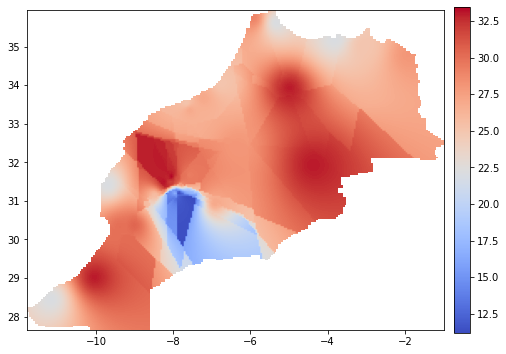

In [53]:
idw.idw_interpolation(
    input_point_shapefile="./data/metar_df_coords.shp",
    extent_shapefile="./data/mar_borders/mar_admbnda_adm0_unhcr_20201203.shp",
    column_name="temp",
    power=2,
    search_radious=4,
    output_resolution=250,
)

In [54]:
from pyidw import idw
from sklearn.metrics import mean_squared_error

def search_best_params(power, radius, resolution) :
    try:
        original_value, interpolated_value = idw.accuracy_standard_idw(
            input_point_shapefile="./data/metar_df_coords.shp",
            extent_shapefile="./data/mar_borders/mar_admbnda_adm0_unhcr_20201203.shp",
            column_name="temp",
            power=int(np.round(power,0)), #2
            search_radious=int(np.round(radius,0)), #4
            output_resolution=int(np.round(resolution,0)), #250
        )

        #print("RMSE:", mean_squared_error(original_value, interpolated_value, squared=False))

        return -mean_squared_error(original_value, interpolated_value, squared=False)
    except:
        return -9999

In [55]:
# pip install bayesian-optimization
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'power': (2, 4), 'radius': (2, 10), 'resolution':(250, 5000)}

optimizer = BayesianOptimization(
    f=search_best_params,
    pbounds=pbounds,
    random_state=1,
)




In [56]:
optimizer.maximize(
    init_points=10,
    n_iter=10,
)

|   iter    |  target   |   power   |  radius   | resolu... |
-------------------------------------------------------------
|  1        | -7.04     |  2.834    |  7.763    |  250.5    |
|  2        | -7.243    |  2.605    |  3.174    |  688.6    |
|  3        | -7.275    |  2.373    |  4.764    |  2.135e+0 |
|  4        | -7.004    |  3.078    |  5.354    |  3.505e+0 |
|  5        | -7.08     |  2.409    |  9.025    |  380.1    |
|  6        | -7.002    |  3.341    |  5.338    |  2.904e+0 |
|  7        | -7.313    |  2.281    |  3.585    |  4.054e+0 |
|  8        | -6.876    |  3.937    |  4.507    |  3.539e+0 |
|  9        | -6.934    |  3.753    |  9.157    |  654.0    |
|  10       | -7.438    |  2.078    |  3.359    |  4.421e+0 |
|  11       | -7.084    |  2.837    |  4.059    |  3.538e+0 |
|  12       | -6.945    |  4.0      |  4.361    |  3.54e+03 |
|  13       | -6.984    |  3.99     |  7.54     |  653.2    |
|  14       | -7.023    |  3.313    |  5.919    |  3.539e+0 |
|  15   

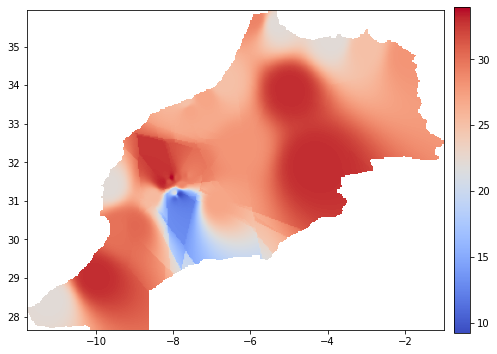

In [59]:
idw.idw_interpolation(
    input_point_shapefile="./data/metar_df_coords.shp",
    extent_shapefile="./data/mar_borders/mar_admbnda_adm0_unhcr_20201203.shp",
    column_name="temp",
    power=4,
    search_radious=5,
    output_resolution=350,
)

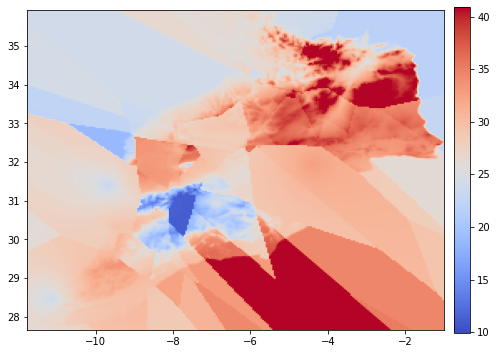

In [57]:
from pyidw import idw

idw.regression_idw_interpolation(
    input_point_shapefile="./data/metar_df_coords.shp",
    input_raster_file="./data/DEM_MA_2.tiff",
    extent_shapefile="./data/mar_borders/mar_admbnda_adm0_unhcr_20201203.shp",
    column_name="temp",
    power=1,
    polynomial_degree=1,
    search_radious=4,
    output_resolution=250,
)

In [1]:
from selenium import webdriver
from time import sleep
from selenium.webdriver import FirefoxOptions

opts = FirefoxOptions()
opts.add_argument("--headless")

# https://stackoverflow.com/questions/41190989/how-do-i-install-geckodriver
# https://stackoverflow.com/questions/46809135/webdriver-exceptionprocess-unexpectedly-closed-with-status-1
# pip install webdrivermanager
# sudo apt-get install firefox
# webdrivermanager firefox --linkpath /usr/local/bin
# sudo apt install firefox-geckodriver

driver = webdriver.Firefox(options=opts)
driver.set_window_size(900, 900)
driver.get('https://weathermap.netatmo.com//?zoom=8.33607807648677&type=temp&param=Filter&stationid=70%3Aee%3A50%3A6b%3A60%3Ab8&maplayer=Map&lang=fr')
sleep(10)

driver.get_screenshot_as_file("./data/screenshot.png")
driver.quit()
print("end...")



end...
